-------
Yolov3 predictions for original image:
     scores  labels
0  0.998873       0
1  0.996885       0
2  0.979744       0
3  0.952768       0
4  0.924878       0
5  0.922550       0


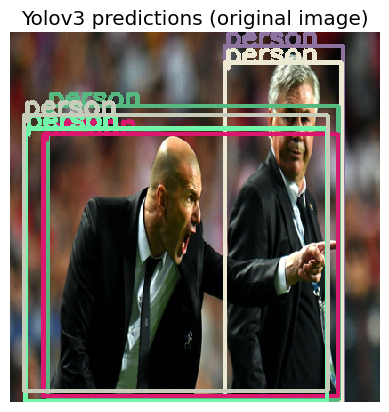

In [2]:
"""
The script demonstrates a simple example of using ART with Yolov3. The example loads a model pretrained on the COCO dataset
and creates an adversarial example using Projected Gradient Descent method.

*** Note ***
Requires modifying pytorchyolo/utils/loss.py, before line 174, add the following:
gain = gain.to(torch.int64)
"""
import requests
import numpy as np
from PIL import Image
from io import BytesIO
import torch
import pandas as pd
import numpy as np

from pytorchyolo.utils.loss import compute_loss
from pytorchyolo.models import load_model

from art.estimators.object_detection.pytorch_yolo import PyTorchYolo
from art.attacks.evasion import RobustDPatch

import cv2
import matplotlib
import matplotlib.pyplot as plt

plt.style.use('ggplot')
matplotlib.use( 'tkagg' )
%matplotlib inline

COCO_CATEGORIES = ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light',
        'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
        'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee',
        'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard',
        'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
        'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch',
        'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 
        'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 
        'teddy bear', 'hair drier', 'toothbrush']

def extract_predictions(predictions_):
    # Get the predicted class
    predictions_class = [COCO_CATEGORIES[i] for i in list(predictions_["labels"])]

    # Get the predicted bounding boxes
    predictions_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(predictions_["boxes"])]

    # Get the predicted prediction score
    predictions_score = list(predictions_["scores"])

    predictions_boxes = [[tuple([int (i) for i in t]) for t in r] for r in predictions_boxes]

    return predictions_class, predictions_boxes, predictions_class


def plot_image_with_boxes(img, boxes, pred_cls):
    text_size = 1
    text_th = 3
    rect_th = 3
    
    for i in range(len(boxes)):
        
        color = tuple([int(i) for i in list(np.random.choice(range(256), size=3))])
        
        # Draw Rectangle with the coordinates
        cv2.rectangle(img, boxes[i][0], boxes[i][1], color=color, thickness=rect_th)

        # Write the prediction class
        cv2.putText(img, pred_cls[i], boxes[i][0], cv2.FONT_HERSHEY_SIMPLEX, text_size, color, thickness=text_th)

    plt.axis("off")
    plt.imshow(img.astype(np.uint8), interpolation="nearest")
    plt.show()
    
class YoloV3(torch.nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, x, targets=None):
        if self.training:
            outputs = self.model(x)
            # loss is averaged over a batch. Thus, for patch generation use batch_size = 1
            loss, loss_components = compute_loss(outputs, targets, self.model)
            loss_components_dict = {"loss_total": loss}
            return loss_components_dict
        else:
            return self.model(x)
    
    
response = requests.get('https://ultralytics.com/images/zidane.jpg')
image = np.asarray(Image.open(BytesIO(response.content)).resize((416, 416)))
img_reshape = image.transpose(2,0,1)
img = np.stack([img_reshape], axis=0).astype(np.float32) 
x = img.copy()

'''image_1 = cv2.imread('./zidane.png')
image_1 = cv2.cvtColor(image_1, cv2.COLOR_BGR2RGB)  # Convert to RGB
image_1 = cv2.resize(image_1, dsize=(416, 416), interpolation=cv2.INTER_CUBIC)
x = np.stack([image_1.transpose(2,0,1)], axis=0).astype(np.float32)'''

model_path = "./../../yolov3.cfg"
weights_path = "./../../yolov3.weights"
model = load_model(model_path=model_path, weights_path=weights_path)
        
model = YoloV3(model)

detector = PyTorchYolo(model=model,
                       device_type='cpu',
                       input_shape=(3, 416, 416),
                       clip_values=(0, 255), 
                       attack_losses=("loss_total",))

predictions_orig = detector.predict(x=x)[0]

threshold = 0.8
scores = pd.DataFrame(predictions_orig['scores'], columns=['scores']) 
labels = pd.DataFrame(predictions_orig['labels'], columns=['labels'])
df = pd.concat([scores, labels], axis=1)
df = df[df.scores>threshold]
df = df.sort_values('scores', ascending=False).reset_index()
print('-------')
print('Yolov3 predictions for original image:')
print(df[['scores', 'labels']].head(10))

n_boxes = []
for i, row in df.iterrows():
    n_boxes.append(predictions_orig['boxes'][int(row['index'])].astype(np.int32))

n_predictions = {'boxes': np.array(n_boxes), 
                 'scores': df.scores.values, 
                 'labels': df.labels.values}

# Process predictions
predictions_orig_class, predictions_orig_boxes, predictions_orig_class = extract_predictions(n_predictions)

plt.title("Yolov3 predictions (original image)")
# Plot predictions
plot_image_with_boxes(img=image.copy(), boxes=predictions_orig_boxes, pred_cls=predictions_orig_class)


In [7]:
attack = RobustDPatch(
    detector,
    patch_shape=[3, 100, 100],
    batch_size=1,
    sample_size=1,
    max_iter=50,
    learning_rate=1.0,
    crop_range= [0, 0],
    brightness_range= [1.0, 1.0],
    rotation_weights= [1, 0, 0, 0],
)

patch = attack.generate(x)

RobustDPatch iteration:   0%|          | 0/50 [00:00<?, ?it/s]

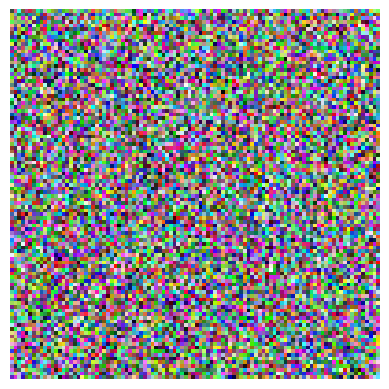

In [8]:
plt.axis("off")
plt.imshow((patch).transpose(1,2,0).astype(np.uint8))
plt.show()

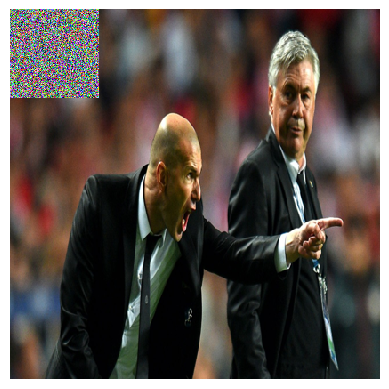

In [9]:
plt.axis("off")
patched_image = attack.apply_patch(x)
plt.imshow(patched_image[0].transpose(1,2,0).astype(np.uint8), interpolation="nearest")

-------
Yolov3 predictions for patched image:
     scores  labels
0  0.999567       0
1  0.998971       0
2  0.998514       0
3  0.995317       0
4  0.992002       0
5  0.984774       0
6  0.970210       0
7  0.953821       0


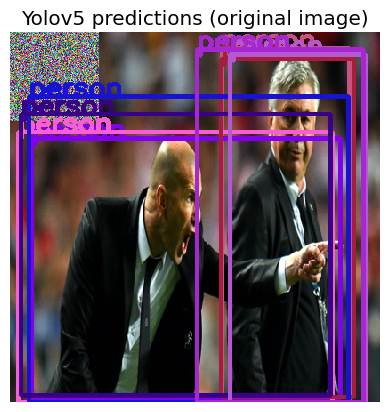

In [10]:
predictions = detector.predict(x=patched_image)[0]


threshold = 0.95
scores = pd.DataFrame(predictions['scores'], columns=['scores']) 
labels = pd.DataFrame(predictions['labels'], columns=['labels'])
df = pd.concat([scores, labels], axis=1)
df = df[df.scores>threshold]
df = df.sort_values('scores', ascending=False).reset_index()
print('-------')
print('Yolov3 predictions for patched image:')
print(df[['scores', 'labels']].head(10))

n_boxes = []
for i, row in df.iterrows():
    n_boxes.append(predictions['boxes'][int(row['index'])].astype(np.int32))

n_predictions = {'boxes': np.array(n_boxes), 
                 'scores': df.scores.values, 
                 'labels': df.labels.values}

# Process predictions
predictions_class, predictions_boxes, predictions_class = extract_predictions(n_predictions)

plt.title("Yolov5 predictions (original image)")
# Plot predictions
plot_image_with_boxes(img=patched_image[0].transpose(1,2,0).copy(), boxes=predictions_boxes, pred_cls=predictions_class)       

-------
Yolov3 predictions for patched image:
     scores  labels
0  0.998873       0
1  0.996888       0
2  0.979645       0
3  0.952146       0
4  0.923440       0
5  0.919090       0


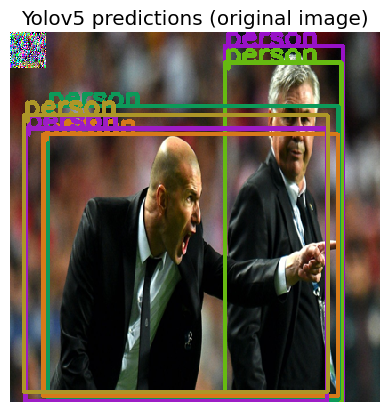

In [6]:
model_path = "./tmp/yolov3.cfg"
weights_path = "./tmp/yolov3.weights"
model = load_model(model_path=model_path, weights_path=weights_path)
        
model = YoloV3(model)

detector = PyTorchYolo(model=model,
                       device_type='cpu',
                       input_shape=(3, 416, 416),
                       clip_values=(0, 255), 
                       attack_losses=("loss_total",))


patched_image = attack.apply_patch(x)
predictions = detector.predict(x=patched_image)[0]


threshold = 0.85
scores = pd.DataFrame(predictions['scores'], columns=['scores']) 
labels = pd.DataFrame(predictions['labels'], columns=['labels'])
df = pd.concat([scores, labels], axis=1)
df = df[df.scores>threshold]
df = df.sort_values('scores', ascending=False).reset_index()
print('-------')
print('Yolov3 predictions for patched image:')
print(df[['scores', 'labels']].head(10))

n_boxes = []
for i, row in df.iterrows():
    n_boxes.append(predictions['boxes'][int(row['index'])].astype(np.int32))

n_predictions = {'boxes': np.array(n_boxes), 
                 'scores': df.scores.values, 
                 'labels': df.labels.values}

# Process predictions
predictions_class, predictions_boxes, predictions_class = extract_predictions(n_predictions)

plt.title("Yolov5 predictions (original image)")
# Plot predictions
plot_image_with_boxes(img=patched_image[0].transpose(1,2,0).copy(), boxes=predictions_boxes, pred_cls=predictions_class)       